#Diagram for Mamba

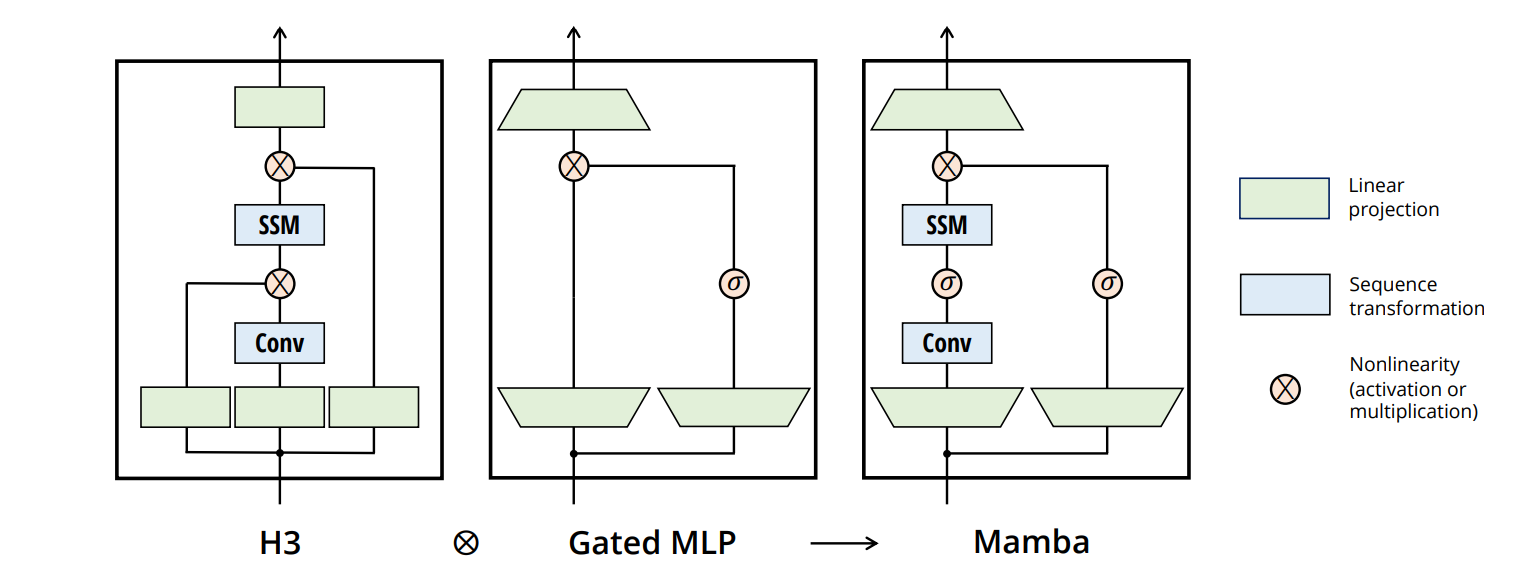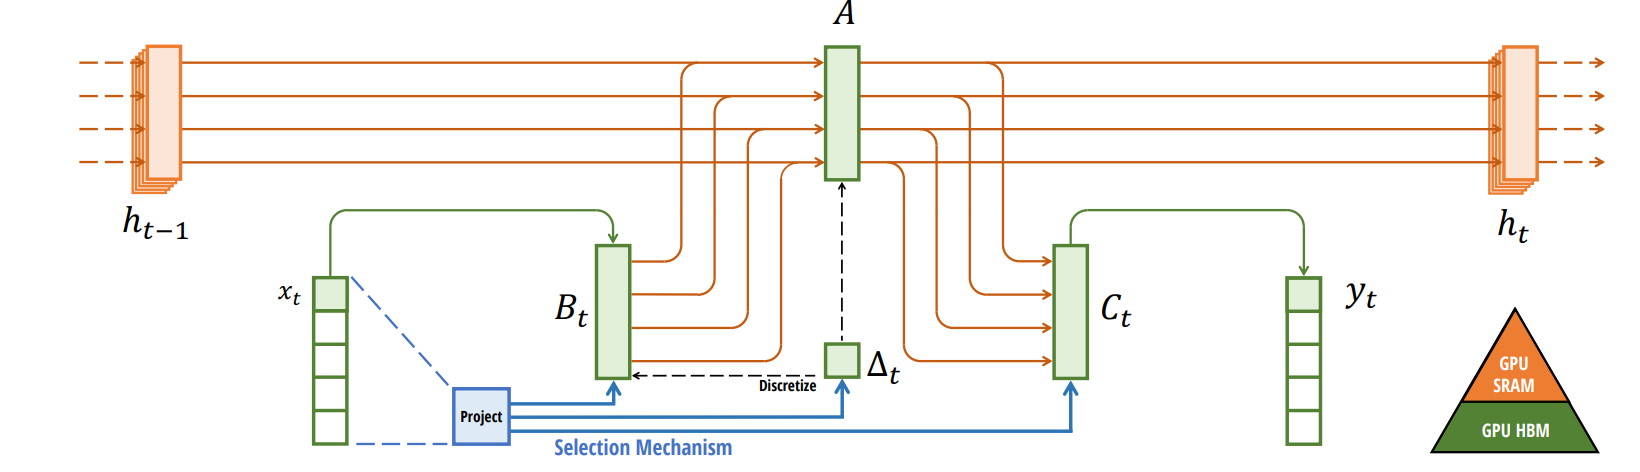

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from einops import einsum,rearrange,repeat

In [ ]:
class HybridConfig:
  def __init__(self):
    self.vocab_size=50257
    self.n_head=8
    self.n_embd=1024
    self.block_size=4048
    self.dropout=0.1
    self.n_intmd=2048
    self.ssm_hid=64
    self.kernel=4
    self.num_layers=96
    self.layer_pattern="MMA"*32
    self.ssm_delta=64

In [ ]:
class MHA(nn.Module):
  def __init__(self,config:HybridConfig):
    super().__init__()
    assert config.n_embd%config.n_head==0
    self.n_embd=config.n_embd
    self.n_head=config.n_head
    self.attn_proj=nn.Linear(config.n_embd,3*config.n_embd)
    self.c_proj=nn.Linear(config.n_embd,config.n_embd)
    self.d_k=self.n_embd//self.n_head
    self.register_buffer('bias',torch.tril(torch.ones((1,1,config.block_size,config.block_size))))
    self.attn_dropout=nn.Dropout(config.dropout)
    self.resid_dropout=nn.Dropout(config.dropout)
  def forward(self,x):
    B,T,C=x.shape
    q,k,v=self.attn_proj(x).split(self.n_embd,dim=-1)
    q=q.view(B,T,self.n_head,self.d_k).transpose(1,2)
    k=k.view(B,T,self.n_head,self.d_k).transpose(1,2)
    v=v.view(B,T,self.n_head,self.d_k).transpose(1,2)
    attn=(q@k.transpose(-1,-2))*(1/(math.sqrt(self.d_k)))
    attn=attn.masked_fill(self.bias[:,:,:T,:T]==0,float('-inf'))
    attn=F.softmax(attn,dim=-1)
    attn=self.attn_dropout(attn)

    y=attn@v
    y=y.transpose(1,2).contiguous().view(B,T,C)
    return self.resid_dropout(self.c_proj(y))






In [ ]:
class SSM(nn.Module):
  def __init__(self,config:HybridConfig):
    super().__init__()
    self.ssm_hid=config.ssm_hid
    self.intermediate_size=config.n_intmd
    self.in_proj=nn.Linear(config.n_embd,config.n_intmd*2)
    self.conv=nn.Conv1d(in_channels=config.n_intmd,out_channels=config.n_intmd,kernel_size=config.kernel,groups=config.n_intmd,padding=config.kernel-1)
    self.x_proj=nn.Linear(config.n_intmd,2*config.ssm_hid+1)
    self.A=nn.Parameter(torch.randn([config.n_intmd,config.ssm_hid]))
    self.D=nn.Parameter(torch.ones([config.n_intmd]))
    self.out_proj=nn.Linear(config.n_intmd,config.n_embd)
  def forward(self,x):
    batch_size,T,_=x.shape
    xz=self.in_proj(x)
    x,z=xz.chunk(2,dim=-1)
    x=self.conv(x.transpose(1,2))[:,:,:T].transpose(1,2)
    x=F.silu(x)
    delta,B,C=self.x_proj(x).split([1,self.ssm_hid,self.ssm_hid],dim=-1)
    delta=F.softplus(delta)
    A=-torch.exp(self.A)
    decay=torch.exp(delta.unsqueeze(-1)*A.unsqueeze(0).unsqueeze(0))
    states=x.unsqueeze(-1)*B.unsqueeze(2)*decay
    y=(states*C.unsqueeze(2)).sum(dim=-1)
    y=y+x*self.D.unsqueeze(0).unsqueeze(0)
    return self.out_proj(y*F.silu(z))

In [ ]:
class Mamba(nn.Module):
  def __init__(self,config:HybridConfig):
    super().__init__()
    self.ssm_hid=config.ssm_hid
    self.intermediate_size=config.n_intmd
    self.delta_rank=config.ssm_delta

    self.in_proj=nn.Linear(config.n_embd,config.n_intmd*2)

    self.conv=nn.Conv1d(in_channels=config.n_intmd,out_channels=config.n_intmd,kernel_size=config.kernel,padding=config.kernel-1,groups=config.n_intmd)

    self.x_proj=nn.Linear(config.n_intmd,config.ssm_delta+2*config.ssm_hid)
    self.delta_proj=nn.Linear(config.ssm_delta,config.n_intmd)

    self.A=repeat((torch.arange(config.ssm_hid)),'n -> d n',d=config.n_intmd)
    self.A_log=nn.Parameter(torch.log(self.A))
    self.D=nn.Parameter(torch.ones(config.n_intmd))

    self.out_proj=nn.Linear(config.n_intmd,config.n_embd)

  def forward(self,x):
    batch_size,seq_len,_=x.shape
    xz=self.in_proj(x)
    xz=rearrange(xz,"b l x -> b x l")
    x,z=xz.chunk(2,dim=1)

    x=self.conv(x)[:,:,:seq_len]
    x=F.silu(x)

    y=self.ssm(x)

    y=y*F.silu(z)

    output=self.out_proj(rearrange(y,"b d l -> b l d"))

    return output
    print(output.shape,z.shape)

  def ssm(self,x):

    A=-torch.exp(self.A_log.float())
    D=self.D.float()

    x_rearrange=rearrange(x,'b d l -> b l d')
    x_rearrange=self.x_proj(x_rearrange)
    delta,B,C=x_rearrange.split([self.delta_rank,self.ssm_hid,self.ssm_hid],dim=-1)
    delta=F.softplus(self.delta_proj(delta))

    y=self.selective_scan(x,A,B,C,D,delta)

    return y

  def selective_scan(self,u,A,B,C,D,delta):
    b,d_in,l=u.shape
    n=A.shape[1]
    deltaA=torch.exp(einsum(delta,A,'b l d_in , d_in n -> b d_in l n'))
    deltaB_u=einsum(delta,B,u,'b l d_in , b l n , b d_in l -> b d_in l n')
    x=torch.zeros((b,d_in,n),device=next(self.parameters()).device)
    ys=[]
    for i in range(l):
      x=deltaA[:,:,i]*x+deltaB_u[:,:,i]
      y=einsum(x,C[:,i,:],'b d_in n , b n -> b d_in')
      ys.append(y)
    y=torch.stack(ys,dim=2)

    y=y+u*rearrange(D,'d_in -> d_in 1')

    return y

In [ ]:
l=HybridConfig()
t=Mamba(l)

In [ ]:
t(torch.randn(5,32,1024))

tensor([[[-0.0349, -0.0127,  0.0736,  ...,  0.0076, -0.0111, -0.0558],
         [-0.0127,  0.0063,  0.0120,  ...,  0.0204, -0.0160, -0.0465],
         [ 0.0167,  0.0546, -0.0119,  ...,  0.0239, -0.0115,  0.0187],
         ...,
         [-0.0069, -0.0301, -0.0178,  ..., -0.0344,  0.0266, -0.0265],
         [-0.0590,  0.0302,  0.0039,  ...,  0.0169,  0.0208,  0.0087],
         [-0.0346, -0.0133, -0.0222,  ..., -0.0025, -0.0278,  0.0144]],

        [[-0.0333,  0.0230,  0.0004,  ...,  0.0068,  0.0579,  0.0031],
         [-0.0371, -0.0306, -0.0350,  ...,  0.0084,  0.0473, -0.0225],
         [ 0.0158, -0.0119,  0.0224,  ...,  0.0021, -0.0150, -0.0548],
         ...,
         [-0.0459,  0.0306,  0.0010,  ..., -0.0368, -0.0143, -0.0006],
         [ 0.0112,  0.0088, -0.0780,  ..., -0.0490, -0.0170,  0.0238],
         [ 0.0186, -0.0095,  0.0488,  ...,  0.0018,  0.0620, -0.0564]],

        [[ 0.0608, -0.0350,  0.0630,  ...,  0.0133, -0.0189,  0.0734],
         [-0.0675, -0.0341,  0.0016,  ..., -0

In [ ]:
class BasicMLP(nn.Module):
  def __init__(self,config:HybridConfig):
    super().__init__()
    self.net=nn.Sequential(
        nn.Linear(config.n_embd,4*config.n_embd),
        nn.GELU(),
        nn.Linear(4*config.n_embd,config.n_embd)
    )
  def forward(self,x):
    return self.net(x)

In [ ]:
class MLP(nn.Module):
  def __init__(self,config:HybridConfig):
    super().__init__()
    self.up_proj=nn.Linear(config.n_embd,config.n_embd*4)
    self.gate_proj=nn.Linear(config.n_embd,config.n_embd*4)
    self.down_proj=nn.Linear(config.n_embd*4,config.n_embd)
  def forward(self,x):
    return self.down_proj(self.up_proj(x)*F.silu(self.gate_proj(x)))

In [ ]:
class HybridBlock(nn.Module):
  def __init__(self,config:HybridConfig,layer_idx):
    super().__init__()
    self.rn1=nn.RMSNorm(config.n_embd)
    self.rn2=nn.RMSNorm(config.n_embd)
    self.mixer=Mamba(config) if config.layer_pattern[layer_idx]=="M" else MHA(config)
    self.ff=MLP(config)
  def forward(self,x):
    x=x+self.mixer(self.rn1(x))
    x=x+self.ff(self.rn2(x))
    return x

In [ ]:
class HybridTransformer(nn.Module):
  def __init__(self,config:HybridConfig):
    super().__init__()
    self.block_size=config.block_size
    self.token_emb=nn.Embedding(config.vocab_size,config.n_embd)
    self.pos_emb=nn.Embedding(config.block_size,config.n_embd)
    self.drop=nn.Dropout(config.dropout)
    self.blocks=nn.ModuleList([HybridBlock(config,i) for i in range(config.num_layers)])
    self.rn=nn.RMSNorm(config.n_embd)
    self.head=nn.Linear(config.n_embd,config.vocab_size)
  def forward(self,ids,labels=None):
    B,T=ids.shape
    assert T<=self.block_size
    pos=torch.arange(0,T,dtype=torch.long,device=ids.device).unsqueeze(0)
    emb_ids=self.token_emb(ids)+self.pos_emb(pos)
    x=self.drop(emb_ids)

    for blk in self.blocks:
      x=blk(x)

    x=self.rn(x)
    logits=self.head(x)
    loss=None
    if labels is not None:
      loss=F.cross_entropy(logits.view(-1,logits.size(-1)),labels.view(-1))
    return logits,loss
  @torch.no_grad()
  def generate(self,idx,max_tokens=50,temprature=0.8,topk=None):
    for _ in range(max_tokens):
      idx=idx[:,-self.block_size:]
      logits,_=self(idx)
      logit=logits[:,-1,:]/temprature
      if topk is not None:
        v,i=torch.topk(logit,topk)
        mask=logit<v[:,-1].unsqueeze(-1)
        mask=mask.to(logit.device)
        logit[mask]=float("-inf")
      prob=F.softmax(logit,dim=-1)
      next_token=torch.multinomial(prob,num_samples=1)
      idx=torch.concat([idx,next_token],dim=-1)
      if next_token.item()==eot_token:
        break
    return idx


In [ ]:
eot_token=50257

In [ ]:
c=HybridConfig()
attn=HybridTransformer(c)

In [ ]:
# attn.generate(torch.randint(0,5000,(1,1)))

In [ ]:
def count_parameters(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total:,}")
    print(f"Trainable parameters: {trainable:,}")
    return total, trainable


In [ ]:
count_parameters(attn)

Total parameters: 1,896,366,161
Trainable parameters: 1,896,366,161


(1896366161, 1896366161)

In [ ]:
!pip install torchprofile

In [ ]:
from torchprofile import profile_macs

In [ ]:
macs=profile_macs(attn,torch.randint(0,5000,(128,1)))

In [ ]:
flops = 2 * macs
print(f"Estimated FLOPs for forward pass: {flops:.2e}")